In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
import itertools as it
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [214]:
L, R = 4000, 5
mesh_x = Multidomain(Legendre(20), np.linspace(0, L, 121))
mesh_r = Legendre(4, (R, 0), 'Radau')
mesh_phi = Constant()
mesh = mesh_x*mesh_r*mesh_phi

Nx, Nr, Nphi = mesh.shape

rho = 1.06; young = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

x_field, r_field, phi_field = TensorField(mesh, np.meshgrid(*mesh.grid(), indexing='ij'))
c = np.sqrt(young/rho)
def damp(t):
    data = 10*np.cos(np.pi*(x_field.func - 0*t)/L)**400
    return TensorField(mesh, data)

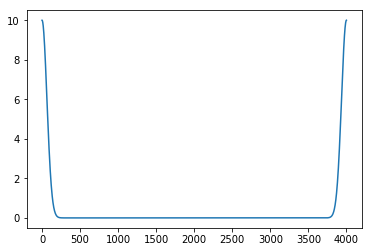

In [215]:
plt.plot(x_field.func[:,0,0], damp(0)(x_field.func[:,0,0],0,0))

In [216]:
def cauchy_green(u):
    deform = u.grad(coord='cylindrical')
    return 1/2*(deform + deform.T + deform@deform.T)

def kin_energy(v):
    return rho*(v@v).int(coord='cylindrical')/2

def pot_energy(u):
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    I3 = CG.det()
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2 + (l + 2*m)/3*I1**3 - 2*m*I1*I2 + n*I3
    return pot.int(coord='cylindrical')

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [218]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v - damp(t)*u
    
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    dI3 = CG.cofactor_matrix()
    
    PK = ((lam + 2*mu)*I1*dI1 - 2*mu*dI2 + (l + 2*m)*I1**2*dI1 
          - 2*m*(dI1*I2 + I1*dI2) + n*dI3)@(np.eye(3) + u.grad(coord='cylindrical'))
    
    bval = (0, 0), (f(t), 0), (0, 0)
    F = PK.div(bval, coord='cylindrical')
    #F -= damp(t)*v
    F = F.match_domains()  
    
    dv_dt = F/rho
    
    return compress(du_dt, dv_dt)

# Moving tangential loading

In [144]:
%%time
t0 = 0
t_max = 2000.0
dt = 10.0
T = np.arange(t0, t_max, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

grid_x = np.array(mesh_x.grid()[0])

def f(t):
    A_stress = 1e-3*young
    D = 2e3*A_stress
    F = np.zeros((3, Nx, 1))
    arg = (grid_x - c*t)%L - L/2
    F[1] = (A_stress*young*np.cosh(arg/D)**(-2))[:,None]
    return F

CPU times: user 511 µs, sys: 15 µs, total: 526 µs
Wall time: 534 µs


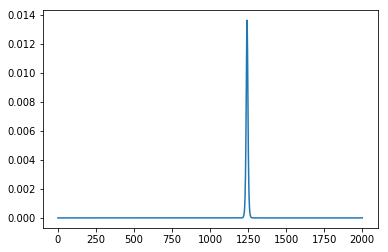

In [145]:
plt.plot(grid_x, f(T[13])[1,:,0])

In [207]:
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

In [208]:
fig, ax = plt.subplots()
plt.xlim(0, L)
plt.ylim(-1e-1/2, 1e-1)
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    x = np.linspace(0, L, 400)
    line.set_data(x, u(x + c*T[k]))
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

In [209]:
anim

In [213]:
direct = 'FullEqn_tan_force_soliton_gen_PS/'

In [215]:
np.save(direct + 'mesh_grid.npy', mesh.grid())
np.save(direct + 'displacement.npy', U.func)
np.save(direct + 'time.npy', T)
np.save(direct + 'energy.npy', E)

In [12]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1800)
anim.save('b_impact.mp4', writer=writer)

# Static normal loading

In [219]:
tau = 10
t0 = -6*tau
t_max = 1000.0
dt = 10.0
T = np.arange(t0, t_max, dt)

u_data = np.zeros((3,) + mesh.shape)
u_data[0] += -A0*width*sp.special.erf((x_field.func - 100)/width)
u0 = TensorField(mesh, u_data)
u0[1] -= nu*r_field*u0[0].diff(0)
v0 = -c*u0.diff()

u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

grid_x = np.array(mesh_x.grid()[0])

def f(t):
    amplt = 3e-1*np.cosh(t/tau)**(-2)
    F = np.zeros((3, Nx, 1))
    F[1] = amplt*(np.cosh((grid_x - L/2)/15)**(-2))[:,None]
    return F

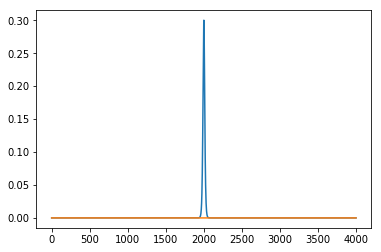

In [220]:
plt.plot(grid_x, f(0)[1,:,0], grid_x, -u0[0].diff(0)(grid_x, 0, 0))

In [221]:
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

In [222]:
fig, ax = plt.subplots()
plt.xlim(0, L)
plt.ylim(-1e-1/2, 1e-1)
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()
x = np.linspace(0, L, 2000)

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    line.set_data(x, u(x + 0*T[k]))
    time_text.set_text(time_template % T[k])
    return line, time_text

animation.FuncAnimation(fig, animate, frames=len(T), 
                        interval=50, blit=True)

In [223]:
direct = 'FullEqn_norm_force_soliton_gen_PS/'
np.save(direct + 'mesh_grid.npy', mesh.grid())
np.save(direct + 'displacement.npy', U.func)
np.save(direct + 'time.npy', T)
np.save(direct + 'energy.npy', E)